# **Istruzioni**

Questo è un semplice notebook di esempio che mostra come effettuare il fine tuning di una rete pre-addestrata.

Per l'implementazione è stata ultilizzata la libreria di python PyTorch
https://pytorch.org/docs/stable/index.html



#Connessione a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import delle librerie utili

In [ ]:
###########################
# IMPORT
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as dataloader
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
import matplotlib.pyplot as plt
######################################

# Collegamento alla GPU offerta da Google


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.10.0+cu111
False


RuntimeError: ignored

# Dataloaders

In [ ]:
class NumpyDataset(dataloader.Dataset):
  def __init__(self, root_path):
    self.data_numpy_list = next(os.walk(root_path))[2] 
    self.data_list = []
    self.class_list = []
    for ind in range(len(self.data_numpy_list)):
      data_slice_file_name = root_path + self.data_numpy_list[ind]
      data_i = np.load(data_slice_file_name, allow_pickle=True)
      self.data_list.append(data_i[0])
      self.class_list.append(data_i[1])

  def __getitem__(self, index):
    self.data = np.asarray(self.data_list[index])
    self.data = np.resize(self.data,(224,224))   #resize
    self.data = np.stack((self.data, self.data, self.data))   #1 to 3 channels
    self.data[0,:,:] = (self.data[0,:,:] - 0.485)/0.229       #norm channel 0
    self.data[1,:,:] = (self.data[1,:,:] - 0.456)/0.224       #norm channel 1
    self.data[0,:,:] = (self.data[2,:,:] - 0.406)/0.225       #norm channel 2
    return torch.from_numpy(self.data).float(), self.class_list[index]

  def __len__(self):
    return len(self.data_numpy_list)
    


# Utility per il managment dei dati per la CNN

In [ ]:
image_datasets = {x: NumpyDataset("/content/drive/MyDrive/Dataset/" + x +"/") for x in ['training_set',
                                                                                        'validation_set']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['training_set', 
                                                                                    'validation_set']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training_set', 'validation_set']}

print(str(dataset_sizes['training_set']) + " Training set dimension before split")
print(str(dataset_sizes['validation_set']) + " Validation set dimension")

local_test, train = torch.utils.data.random_split(image_datasets['training_set'], [170,687])
image_datasets['test_set'] = local_test
image_datasets['training_set'] = train

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['training_set', 
                                                                                    'validation_set', 
                                                                                    'test_set']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training_set', 'validation_set', 'test_set']}
print('---'*5)
print(str(dataset_sizes['training_set']) + " Training set dimension after split")
print(str(dataset_sizes['validation_set']) + " Validation set dimension")
print(str(dataset_sizes['test_set']) + " Local test set dimension after split")

857 Training set dimension before split
170 Validation set dimension
---------------
687 Training set dimension after split
170 Validation set dimension
170 Local test set dimension after split


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import seaborn as sns
for x in ['training_set', 'validation_set', 'test_set']:
  df_train = pd.DataFrame.from_dict(image_datasets, orient='index')
#train = train.append(image_datasets['training_set'], ignore_index=True)
print(df_train.head())


                                                                0
training_set    (([tensor([[ -6.0541,  -5.9819,  -6.5115,  ......
validation_set  (([tensor([[ -2.0326,  -4.1240,  -7.0831,  ......
test_set        (([tensor([[ -6.5102,  -6.7703,  -9.7862,  ......


In [ ]:
#graph_dataset = {x: NumpyDataset("/content/drive/MyDrive/Dataset/" + x +"/").numpy() for x in ['training_set', 'validation_set']}
print(type(image_datasets['training_set'][5]))
print(image_datasets['training_set'][5])
graph_data_train = list(image_datasets['training_set'])

print(graph_data_train[100])
#sns.countplot(graph_data_train)

<class 'tuple'>
(tensor([[[-22.2719, -22.2719, -22.2719,  ..., -22.2719, -22.2719, -22.2719],
         [-22.2719, -22.2719, -22.2719,  ..., -21.4931, -21.2607, -21.6271],
         [-11.2217, -14.9896,  -9.5242,  ...,  -7.6871,  -8.2013, -10.4979],
         ...,
         [-12.2031, -11.4126, -11.4809,  ..., -12.3923, -12.1780, -12.3793],
         [ -2.8648,  -1.6337,  -1.9518,  ..., -10.2078, -11.2774, -11.1311],
         [-11.6041, -11.8822, -14.4455,  ..., -12.2096, -11.8607, -11.7594]],

        [[-22.5945, -22.5945, -22.5945,  ..., -22.5945, -22.5945, -22.5945],
         [-22.5945, -22.5945, -22.5945,  ..., -21.8123, -21.5789, -21.9468],
         [-11.4950, -15.2798,  -9.7899,  ...,  -7.9447,  -8.4611, -10.7679],
         ...,
         [-12.4808, -11.6867, -11.7553,  ..., -12.6709, -12.4556, -12.6578],
         [ -3.1008,  -1.8642,  -2.1837,  ..., -10.4766, -11.5510, -11.4040],
         [-11.8791, -12.1584, -14.7332,  ..., -12.4873, -12.1368, -12.0351]],

        [[ -4.6052,  -4.605

KeyError: ignored

In [ ]:
df_train[0].sample(3)[0].dtype()

AttributeError: ignored

# Procedura di training da effettuare

Per effettuare il training della mia rete convoluzionale devo seguire diversi passaggi:
- Creazione del **training set**;
- Creazione del **validation set**;
- Settaggio degli iperparametri (*batch size*, *learning rate*);
- Per ogni epoca:
  - Splittare il **training set** nei batch della dimensione corretta;
  - Per ogni batch:
    - Dare in input alla rete le istanze all'interno del batch;
    - Calcolo del *loss*;
    - Calcolo del *gradiente*;
    - Aggiornamento dei parametri
  -Calcolo delle performance sul **validation set**

## Ispezione livello convoluzionale 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
#[N, C, H, W]
#1, 1, 5, 5
x = torch.rand(3,1,10,10) 
print(conv_layer(x).shape)
print(count_parameters(conv_layer))

torch.Size([3, 1, 4, 4])
10


#Definizione Funzioni

La funzione *train_model* è di esempio per il train di una rete.





In [ ]:
#find best model on validation test
def train_loop_validation(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv,
                          best_acc, best_loss, best_epoca, outputPath):
  
  for epochs in range(startEpoch, numEpochs + 1):
    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0

    model_conv.train() 

    totalSize = 0
    
    
    #for each batch
    for inputs, labels in dataloaders['training_set']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch 

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      optimizer_conv.step()
    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders['validation_set']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      y = model_conv(inputs) #16x29
      outp, preds = torch.max(y, 1) 
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
          %(epochs, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
      print('     .... Saving best weights ....')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')
      
    with open(outputPath + 'lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')
      
    with open(outputPath + 'AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')
      
    with open(outputPath + 'lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')
      
    with open(outputPath + 'AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')
      
    sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc, 
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})
  file_object.close()

# Funzione di riaddestramento della rete

In [ ]:
def retrain_loop_validation(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv,
                          best_acc, best_loss, best_epoca, outputPath):
  
  for epochs in range(startEpoch, numEpochs + 1):
    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0

    model_conv.train() 

    totalSize = 0
    
    
    #for each batch
    for inputs, labels in dataloaders['training_set']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch 

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      optimizer_conv.step()
    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders['validation_set']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      y = model_conv(inputs) #16x29
      outp, preds = torch.max(y, 1) 
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
          %(epochs, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    if (epochs == numEpochs):
      print('     .... Saving best weights ....')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')
      
    with open(outputPath + 'lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')
      
    with open(outputPath + 'AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')
      
    with open(outputPath + 'lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')
      
    with open(outputPath + 'AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')
      
    sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc, 
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})
  file_object.close()

#Parametri

In [ ]:
#rendere l'esecuzione deterministica
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


learning_rate = 0.000001
batch_size = 120
set_classes_number = 3
num_epoch = 220

#Train model

In [ ]:
# -------------------------------------create model------------------------------------------------  
networkName = 'alexnet'
WeightPath = '/content/' + networkName + '/'

try:
  os.makedirs(WeightPath)
except:
  pass
  
model_conv = torchvision.models.alexnet(pretrained=True)
# change last fully connected layer
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)

# set requires_grad=false
for param in model_conv.parameters():
  param.requires_grad = False
  
# train fully connected layers
for param in model_conv.classifier.parameters():
  param.requires_grad = True

print(model_conv)

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)

# -----------------------------------train model--------------------------------------------------  
startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0

train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1][TRAIN on 687 [Loss: 1.3791  ACC: 0.3872]][VAL on 170 [Loss: 1.0845  ACC: 0.4647]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 2][TRAIN on 687 [Loss: 1.0514  ACC: 0.4993]][VAL on 170 [Loss: 0.8961  ACC: 0.5882]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 3][TRAIN on 687 [Loss: 0.9543  ACC: 0.5706]][VAL on 170 [Loss: 0.7933  ACC: 0.6588]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 4][TRAIN on 687 [Loss: 0.8413  ACC: 0.6084]][VAL on 170 [Loss: 0.7269  ACC: 0.6882]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 5][TRAIN on 687 [Loss: 0.8051  ACC: 0.6172]][VAL on 170 [Loss: 0.6829  ACC: 0.7059]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 6][TRAIN on 687 [Loss: 0.7489  ACC: 0.6652]][VAL on 170 [Loss: 0.6490  ACC: 0.7235]][TIME: 0 m 10 s]
     .... Saving best weights ....
[Epoch 7][TRAIN on 687 [Loss: 0.6889  ACC: 0.6943]][VAL on 170 [Loss: 0.6270  ACC: 0.7529]][TIME: 0 m 10 s]
     .... Saving best weights ....

#Plot delle curve

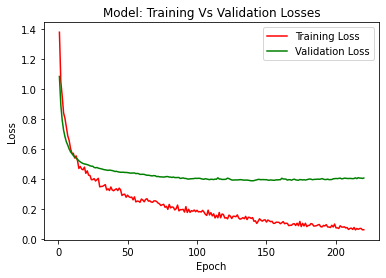

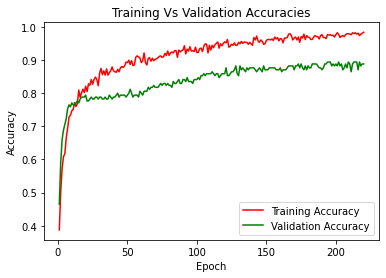

In [ ]:
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

WeightPath = 'alexnet/'
file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(WeightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

file = open(WeightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(WeightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

In [ ]:
!zip -r alexnet.zip alexnet
!cp /content/alexnet.zip gdrive/My\ Drive/DataMining_EsercitazioneDeepLearning/

# Riaddestramento della rete con train + validation

In [ ]:
from torch.utils.data import ConcatDataset

print(str(dataset_sizes['training_set']) + " Training set dimension")
print(str(dataset_sizes['validation_set']) + " Validation set dimension")
print(str(dataset_sizes['test_set']) + " Test set dimension")

print('-----'*5)

new_image_dataset={}
new_image_dataset['training_set'] = train + image_datasets['validation_set']
new_image_dataset['validation_set'] = local_test

new_dataloaders = {x: torch.utils.data.DataLoader(new_image_dataset[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['training_set', 'validation_set']}

new_dataset_size = {x: len(new_image_dataset[x]) for x in ['training_set', 'validation_set']}

#dataset_train_val = ConcatDataset([dataloaders['training_set'], dataloaders['validation_set']])


print(str(new_dataset_size['training_set']) + " Training + Validation set dimension")
print(str(new_dataset_size['validation_set']) + " Test set dimension")



687 Training set dimension
170 Validation set dimension
170 Test set dimension
-------------------------
857 Training + Validation set dimension
170 Test set dimension


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


NameError: ignored

# Grafici per il riaddestramento

# Riaddestramento

In [ ]:
model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)


In [ ]:
# -----------------------------------train model--------------------------------------------------  
startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0


retrain_loop_validation(new_dataloaders, startEpoch, 35, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1][TRAIN on 857 [Loss: 0.1002  ACC: 0.9615]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 2][TRAIN on 857 [Loss: 0.0942  ACC: 0.9697]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 3][TRAIN on 857 [Loss: 0.0715  ACC: 0.9767]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 4][TRAIN on 857 [Loss: 0.0847  ACC: 0.9708]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 5][TRAIN on 857 [Loss: 0.0849  ACC: 0.9708]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 6][TRAIN on 857 [Loss: 0.0879  ACC: 0.9662]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 7][TRAIN on 857 [Loss: 0.0810  ACC: 0.9720]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 8][TRAIN on 857 [Loss: 0.0872  ACC: 0.9697]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 9][TRAIN on 857 [Loss: 0.0857  ACC: 0.9732]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 15 s]
[Epoch 10][TRAIN on 857 [Los

# Plot delle curve di nuovo

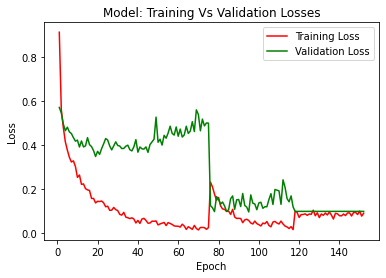

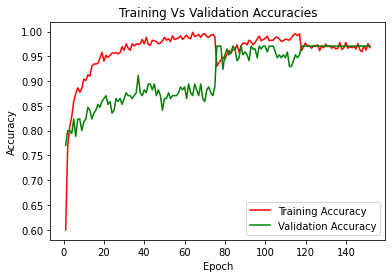

In [ ]:
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

WeightPath = 'alexnet/'
file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(WeightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

file = open(WeightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(WeightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

# Predizione sul test locale

In [ ]:
from PIL import Image


Test_locale = pd.DataFrame()

classes = ['0', '1', '2']
#WeightPath = '/content/' + networkName

model_conv = torchvision.models.alexnet(pretrained=True)
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)
#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)

model_conv.load_state_dict(torch.load(WeightPath + '/best_model_weights.pth'))


#model_conv.load_state_dict(torch.load('/content/gdrive/My Drive/DataMining_EsercitazioneDeepLearning/AlexNet/' + '/best_weight.pth'))
model_conv = model_conv.cuda()
model_conv.eval()

#file = iter(dataloaders['test_set']).numpy()

#out=torch.from_numpy(file).float().cuda()
#outputs = model_conv(out)
#_, predicted = torch.max(outputs, 1)

modelAcc_test_loc = 0.0
totalSize_test_loc = 0


for inputs, labels in new_dataloaders['validation_set']:
    inputs = inputs.type(torch.FloatTensor).cuda()
    labels = labels.cuda()
      
    y = model_conv(inputs) #16x29
    outp, preds = torch.max(y, 1) 
    totalSize_test_loc += inputs.size(0)
    modelAcc_test_loc += torch.sum(preds == labels.data).item()
    
      
modelAcc_test_loc = modelAcc_test_loc/totalSize_test_loc
print(modelAcc_test_loc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9647058823529412


# Unione tra train-validation-test

In [ ]:
from torch.utils.data import ConcatDataset

print('-----'*5)

#new_image_dataset={}
#new_image_dataset['training_set'] = train + image_datasets['validation_set']
#new_image_dataset['validation_set'] = local_test

new_image_dataset_totale = {}
new_image_dataset_totale['training_set'] = new_image_dataset['training_set'] + new_image_dataset['validation_set']
new_image_dataset_totale['validation_set'] = new_image_dataset['validation_set']


new_dataloaders_finale = {x: torch.utils.data.DataLoader(new_image_dataset_totale[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['training_set', 'validation_set']}

new_dataset_size_finale = {x: len(new_image_dataset_totale[x]) for x in ['training_set', 'validation_set']}

#dataset_train_val = ConcatDataset([dataloaders['training_set'], dataloaders['validation_set']])


print(str(new_dataset_size_finale['training_set']) + " Training + Validation + Test set dimension")
print(str(new_dataset_size['validation_set']) + " Test set dimension")

-------------------------
1027 Training + Validation + Test set dimension
170 Test set dimension


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Ri-Riallenamento della rete con tutti i dati con prova a cazzo sul test

In [ ]:
startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0

retrain_loop_validation(new_dataloaders_finale, startEpoch, 35, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1][TRAIN on 1027 [Loss: 0.1012  ACC: 0.9649]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 18 s]
[Epoch 2][TRAIN on 1027 [Loss: 0.0873  ACC: 0.9737]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 18 s]
[Epoch 3][TRAIN on 1027 [Loss: 0.1021  ACC: 0.9679]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 18 s]
[Epoch 4][TRAIN on 1027 [Loss: 0.0814  ACC: 0.9708]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 5][TRAIN on 1027 [Loss: 0.0873  ACC: 0.9679]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 6][TRAIN on 1027 [Loss: 0.0930  ACC: 0.9601]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 7][TRAIN on 1027 [Loss: 0.0882  ACC: 0.9747]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 8][TRAIN on 1027 [Loss: 0.1005  ACC: 0.9581]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 9][TRAIN on 1027 [Loss: 0.0934  ACC: 0.9669]][VAL on 170 [Loss: 0.0990  ACC: 0.9706]][TIME: 0 m 17 s]
[Epoch 10][TRAIN on

# Applicazione della rete sul test vero

In [ ]:
from PIL import Image


Test = pd.DataFrame()

classes = ['0', '1', '2']
#WeightPath = '/content/' + networkName

model_conv = torchvision.models.alexnet(pretrained=True)
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)
#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)

model_conv.load_state_dict(torch.load(WeightPath + '/best_model_weights.pth'))


#model_conv.load_state_dict(torch.load('/content/gdrive/My Drive/DataMining_EsercitazioneDeepLearning/AlexNet/' + '/best_weight.pth'))
model_conv = model_conv.cuda()
model_conv.eval()

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

    

listFile = os.listdir('/content/drive/MyDrive/Dataset/test_set')
for input in listFile:
  print('Working on '+ input)
  file = np.load('/content/drive/MyDrive/Dataset/test_set/' + input)
  file = np.asarray(file)
  file = np.resize(file,(224,224))   #resize
  file = np.stack((file, file, file))   #1 to 3 channels
  file[0,:,:] = (file[0,:,:] - 0.485)/0.229       #norm channel 0
  file[1,:,:] = (file[1,:,:] - 0.456)/0.224       #norm channel 1
  file[0,:,:] = (file[2,:,:] - 0.406)/0.225       #norm channel 2

  file=torch.from_numpy(file).float().cuda()

  file = file.unsqueeze_(0)
  outputs = model_conv(file)
  _, predicted = torch.max(outputs, 1)
  Test = Test.append({'ID': input.split('.')[0],
                      'Class': str(classes[predicted.item()])}, ignore_index = True)

Working on 103.npy
Working on 100.npy
Working on 101.npy
Working on 102.npy
Working on 1.npy
Working on 104.npy
Working on 10.npy
Working on 105.npy
Working on 109.npy
Working on 108.npy
Working on 110.npy
Working on 111.npy
Working on 118.npy
Working on 117.npy
Working on 113.npy
Working on 112.npy
Working on 107.npy
Working on 11.npy
Working on 114.npy
Working on 115.npy
Working on 116.npy
Working on 119.npy
Working on 120.npy
Working on 12.npy
Working on 106.npy
Working on 152.npy
Working on 129.npy
Working on 146.npy
Working on 122.npy
Working on 131.npy
Working on 130.npy
Working on 154.npy
Working on 133.npy
Working on 142.npy
Working on 13.npy
Working on 148.npy
Working on 147.npy
Working on 137.npy
Working on 124.npy
Working on 126.npy
Working on 155.npy
Working on 150.npy
Working on 151.npy
Working on 136.npy
Working on 14.npy
Working on 121.npy
Working on 123.npy
Working on 138.npy
Working on 15.npy
Working on 140.npy
Working on 139.npy
Working on 143.npy
Working on 134.npy
W

# Creazione del file di Submission

In [ ]:
Test.to_csv("Submission.csv", index=False)